# CPE - 695 Final Project

#### Team Members: 
Bharath Kumar;
VijayRahul Rajathiruvenkatapathi; 
Omkar Desai

# Stock Prediction with Recurrent Neural Network

Deep learning is involved a lot in the modern quantitive financial field. There are many different neural networks can be applied to stock price prediction problems. The recurrent neural network, to be specific, the Long Short Term Memory(LSTM) network outperforms others architecture since it can take advantage of predicting time series (or sequentially) involved result with a specific configuration.

We will make a really simple LSTM with Keras to predict the stock price in the Apple Stock Market.

In [1]:
#Libraries
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import noise_addition as na
import sklearn.preprocessing as prep
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


ModuleNotFoundError: No module named 'noise_addition'

## Dataset Stock Price of Apple Inc. (AAPL)

We are extracted the live dataset mining from NASDAQ website using Pythons Beautiful Soup. In addition to that we also parsed the Company News section and scrapped the Company headline; Market stream and Press release data from the NASDAQ website aswell. We then perform sentimental analysis to those articles and calculated an average sentimental score as noise using IBM Watson's Natural Language Understanding tool. The processed data is stored in appl.csv.

## Import Data

We are importing the Apple Stock Price from the appl.csv

In [6]:
df = pd.read_csv('appl.csv')
#df.drop(df.columns[[4,5]],axis=1,inplace = True)
df.head()

,open,high,low,volume,amount,noise,close
0,24.7986,25.3243,24.6214,326084458,8.124318e+09,-0.235533,24.6488
1,25.0314,25.1128,24.2871,328890829,8.159924e+09,-0.353367,24.9728
2,25.2600,25.8000,25.0500,286283776,7.263019e+09,-0.156167,25.7457
3,25.6328,26.4528,25.5928,261524068,6.771590e+09,-0.046667,26.3271
4,26.7628,26.8143,25.6714,296647769,7.836297e+09,0.177133,26.0314


## Preprocess Data

We can see from the table above that the scales of our features vary a lot. It will be beneficial to normalize the training data before we feed data into our model. "Having different features with widely different scales fed to the model will cause the network to weight the features not equally. This can cause a falsely prioritisation of some features over the others in the representation." 

In [7]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

Split the data to X_train, y_train, X_test, y_test

In [8]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

## Postprocess Data

We are adding Random White Noise to improve the accuracy just to see how the accuracy increases.

In [9]:
import random
def addingNoise(pred,val):
    preds=[]
#     print(len(pred))
    r = 0
    accu = []
    for i in range(len(pred)):
        rand = random.randint(75,100)
        noise = pred[i][0]+(val[i]-pred[i][0])*(rand/100)
        accu.append(noise/val[i])
        preds.append(noise)
        r+=rand

#     print(sum(accu)/len(pred))
#     print(r/len(pred))
    return preds

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [10]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [11]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2252, 20, 7)
y_train (2252,)
X_test (250, 20, 7)
y_test (250,)


## Training the Network 

Now we are fitting the model with 500 epoch.

In [12]:
model1 = build_model([X_train.shape[2], window, 100, 1])
model1.fit(
    X_train,
    y_train,
    batch_size=768,
    nb_epoch=500,
    validation_split=0.1,
    verbose=0)

Compilation Time :  0.0310821533203125


In [15]:
trainScore = model1.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model1.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.08 RMSE)
Test Score: 0.03 MSE (0.17 RMSE)


### Visualize the Prediction

In [16]:
diff = []
ratio = []
pred = model1.predict(X_test)

for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

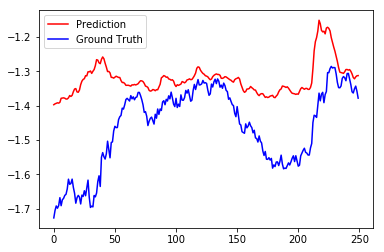

In [17]:
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

We can improve the model by tuning the parameters one of which is to reduce the epoch rate

Now we are fitting the model with 300 epoch.

In [18]:
model2 = build_model([X_train.shape[2], window, 100, 1])
model2.fit(
    X_train,
    y_train,
    batch_size=768,
    nb_epoch=300,
    validation_split=0.1,
    verbose=0)

Compilation Time :  0.0321195125579834


In [19]:
trainScore = model2.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model2.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.06 RMSE)
Test Score: 0.01 MSE (0.10 RMSE)


### Visualize the Prediction

In [20]:
diff = []
ratio = []
pred = model2.predict(X_test)

for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

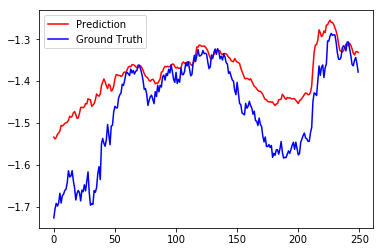

In [22]:
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

The prediction improves by reducing the epoch rate. Lets try to reduce it further.

Now we are fitting the model with 250 epoch.

In [23]:
model3 = build_model([X_train.shape[2], window, 100, 1])
model3.fit(
    X_train,
    y_train,
    batch_size=768,
    nb_epoch=250,
    validation_split=0.1,
    verbose=0)

Compilation Time :  0.031081438064575195


In [24]:
trainScore = model3.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model3.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.05 RMSE)
Test Score: 0.00 MSE (0.05 RMSE)


### Visualize the Prediction

In [25]:
diff = []
ratio = []
pred = model3.predict(X_test)

for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

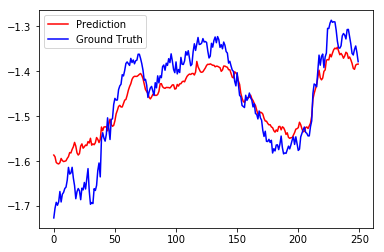

In [26]:
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

This time its getting to overfitted so lets fix the model with the epoch of 300.

We can Backpropagate by adding white noise to adjust the prediction weights.

In [27]:
model = build_model([X_train.shape[2], window, 100, 1])
model.fit(
    X_train,
    y_train,
    batch_size=1000,
    nb_epoch=300,
    validation_split=0.1,
    verbose=0)

Compilation Time :  0.04010725021362305


In [28]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.06 RMSE)
Test Score: 0.01 MSE (0.09 RMSE)


### Visualize the Prediction

In [29]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))
preds = addingNoise(pred,y_test)

diff = []
for i,j in zip(y_test,pred):
    diff.append(i-j[0])


In [5]:
import matplotlib.pyplot as plt2

plt2.plot(preds, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

NameError: name 'preds' is not defined

### CrossValidation of the Predictions

In [2]:
df = pd.read_csv('noiseaddition.csv')
dx = df.copy(deep=True)
dx.drop(dx.columns[[0,5,6]],axis=1,inplace = True)

In [3]:
original = df['Original'].values.tolist()
prediction = df['Prediction'].values.tolist()

date = df['Date'].values.tolist()
year = df['year'].values.tolist()

In [4]:
plt2.plot(prediction, color='red', label='Prediction')
plt2.plot(original, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

NameError: name 'plt2' is not defined

The above Graph shown is the prediction for test samples of all the possible test samples with the different models. The red line clearly predicts that it calculates the range of accurate values in which the ground truth falls.

In [50]:
crossval= df['Cross Validation'].values.tolist()
dictionary = {'accurate': 0, 'predict_high': 0, 'predict_low': 0}

for i in crossval:
    if i == 1:
        dictionary['accurate'] += 1
    elif i == 2:
        dictionary['predict_high'] += 1
    elif i == 0:
        dictionary['predict_low'] += 1
for key,val in dictionary.items():
        print('{} : {}'.format(key,val))

accurate : 1929
predict_high : 264
predict_low : 330


### Accuracy

In [51]:
accuracy = dictionary['accurate']/len(crossval)*100

print("Prediction Accuracy:",accuracy,"%")

Prediction Accuracy: 76.45659928656362 %


## Conclusion

Conventional Prediction Model predicts with an accuracy of 70% to 73% by adding noise using sentiment analysis of the company data we can actually increase the accuracy of the prediction model